In [1]:
import cv2
import glob
import re
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import mean
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import trainable_variables
from tensorflow.compat.v1 import InteractiveSession

### We want to extract every different dish we have in our subfolders

In [2]:
path = "../input/images/"

In [3]:
folders=glob.glob(f'{path}*')

In [4]:
def take_dish_name(path):
    dishes=glob.glob(f'{path}*')
    names=[]
    for dish in dishes:
        names.append(dish.replace(r'../input/images/',''))
    return names

In [5]:
names=take_dish_name(path)

In [6]:
names[0]

'lobster_roll_sandwich'

In [7]:
def pictures_to_df(path="../input/images/"):

    dishes = [
        *glob.glob(f"{path}/**/*.jpg"),
        *glob.glob(f"{path}/**/*.JPG")
    ]
    pictures = pd.DataFrame({
        "path": dishes
    })

    pictures['dish']=pictures.path.apply(lambda x: x.split("/")[3])
    return pictures


In [8]:
pictures=pictures_to_df(path="../input/images/")

In [9]:
le = preprocessing.LabelEncoder()
pictures['dish_ord'] = le.fit_transform(pictures['dish'])

In [10]:
pictures.head()

,path,dish,dish_ord
0,../input/images/lobster_roll_sandwich/2019505.jpg,lobster_roll_sandwich,61
1,../input/images/lobster_roll_sandwich/708911.jpg,lobster_roll_sandwich,61
2,../input/images/lobster_roll_sandwich/784321.jpg,lobster_roll_sandwich,61
3,../input/images/lobster_roll_sandwich/1626426.jpg,lobster_roll_sandwich,61
4,../input/images/lobster_roll_sandwich/849365.jpg,lobster_roll_sandwich,61


In [11]:
clases = dict(zip(pictures.dish.unique(), pictures.dish_ord.unique()))

In [12]:
clases

{'lobster_roll_sandwich': 61,
 'beet_salad': 5,
 'red_velvet_cake': 83,
 'falafel': 36,
 'paella': 71,
 'french_onion_soup': 41,
 'caesar_salad': 11,
 'chicken_quesadilla': 19,
 'beef_carpaccio': 3,
 'macaroni_and_cheese': 62,
 'lobster_bisque': 60,
 'ice_cream': 58,
 'omelette': 67,
 'frozen_yogurt': 45,
 'panna_cotta': 73,
 'beignets': 6,
 'ravioli': 82,
 'tacos': 96,
 'edamame': 33,
 'risotto': 84,
 'creme_brulee': 27,
 'chocolate_mousse': 22,
 'onion_rings': 68,
 'hot_and_sour_soup': 54,
 'pizza': 76,
 'hamburger': 53,
 'cannoli': 12,
 'pancakes': 72,
 'shrimp_and_grits': 89,
 'sashimi': 86,
 'lasagna': 59,
 'hummus': 57,
 'oysters': 69,
 'baby_back_ribs': 1,
 'chocolate_cake': 21,
 'guacamole': 51,
 'fish_and_chips': 38,
 'croque_madame': 28,
 'bread_pudding': 8,
 'eggs_benedict': 34,
 'takoyaki': 97,
 'ceviche': 15,
 'spaghetti_carbonara': 91,
 'scallops': 87,
 'spaghetti_bolognese': 90,
 'tuna_tartare': 99,
 'sushi': 95,
 'french_fries': 40,
 'pulled_pork_sandwich': 80,
 'brusch

### Displaying photos to check them

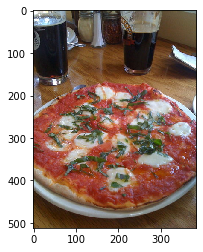

In [13]:
img = Image.open("../input/images/pizza/2965.jpg")
plt.imshow(np.array(img))

In [14]:
pictures_part=pictures[pictures['dish_ord']==0]
for i in range(0,10):
    pictures_part=pictures_part.append(pictures[pictures['dish_ord']==(i+1)])
    

In [15]:
n_clases=len(pictures_part['dish_ord'].unique())

In [16]:
n_pictures=len(pictures_part['dish_ord'])

### We will create X and y to use it fot the neural net afterwards

In [17]:
def arr_from_pic(im):
    img = cv2.imread(im)
    img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    dim=(32,32)
    image=cv2.resize(img2, dim,interpolation=cv2.INTER_AREA)
    return image

In [18]:
images=[]
for image in pictures_part['path']:
    images.append(arr_from_pic(image))

In [19]:
images

[array([[ 94, 110, 140, ..., 164, 154, 157],
        [124, 131, 118, ..., 160, 155, 159],
        [148, 151,  92, ..., 154, 158, 159],
        ...,
        [195, 196, 199, ..., 213, 214, 212],
        [194, 195, 197, ..., 215, 211, 209],
        [195, 196, 198, ..., 210, 208, 207]], dtype=uint8),
 array([[ 16,  26,  26, ...,  83,  46,  45],
        [ 21,  28,  28, ..., 131,  63,  49],
        [ 27,  23,  19, ..., 134,  86,  53],
        ...,
        [181, 193, 191, ..., 174, 174, 182],
        [179, 194, 200, ..., 173, 172, 180],
        [162, 175, 185, ..., 174, 171, 179]], dtype=uint8),
 array([[226, 228, 228, ..., 235, 235, 235],
        [229, 229, 230, ..., 236, 236, 237],
        [228, 229, 231, ..., 237, 237, 237],
        ...,
        [ 88,  64, 112, ..., 115, 103, 101],
        [118,  72,  73, ..., 102, 103, 102],
        [131, 107,  76, ...,  62, 103, 104]], dtype=uint8),
 array([[ 27,  26,  16, ..., 216, 215, 214],
        [ 27,  27,  19, ..., 221, 219, 216],
        [ 29,  2

### We create our X_train and X_test to train out neural net for 3 classes (80-20%)


In [20]:
X = np.asarray(images).astype('float32')/255

In [21]:
X=X.reshape(X.shape[0], 32, 32, 1).astype('float32')/255

In [22]:
X.shape

(11000, 32, 32, 1)

In [23]:
y=to_categorical(np.array(pictures_part['dish_ord']))

In [24]:
y.shape

(11000, 11)

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### We define out net topology

In [26]:
steps=3
n_features=1
batch=256
epocas=1
#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
#optimizer = tf.train.AdamOptimizer(0.001)
opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2 / epocas)
loss='categorical_crossentropy'


In [27]:
modelo=Sequential()
    
modelo.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                  kernel_initializer='he_normal', input_shape=(32,32,1)))

modelo.add(MaxPooling2D((2,2)))
modelo.add(Dropout(0.25))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2)))
modelo.add(Dropout(0.25))
modelo.add(Conv2D(128, (3, 3), activation='relu'))
modelo.add(Dropout(0.4))
modelo.add(Flatten())
modelo.add(Dense(128,  activation='relu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(n_clases, activation='softmax'))

modelo.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         7

### We define earlyStoppingso that fitting stops if loss is not decreasing

In [28]:
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

In [29]:
history=modelo.fit(X_train,y_train, callbacks = [earlystopping], batch_size=batch, epochs=epocas, verbose=0)

In [30]:
history.history['accuracy']

[0.09647727012634277]